# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

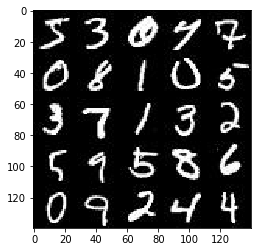

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

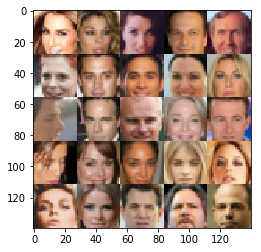

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer 28 x 28 x 3
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(x2, 256, 5, 1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7 x 7 x 256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14 x 14 x 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28 x 28 x 128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 1, padding='same')
        # 28 x 28 x 3

        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    losses = []
    #tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                #endif 
                    
                if steps % 50 == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                #endif
            #end for batch_images
        #end for epoch_i
    #end with
           
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.3316
Epoch 1/2... Discriminator Loss: 0.0150... Generator Loss: 4.5906
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 9.9492
Epoch 1/2... Discriminator Loss: 0.0083... Generator Loss: 14.1496
Epoch 1/2... Discriminator Loss: 0.0024... Generator Loss: 8.2840


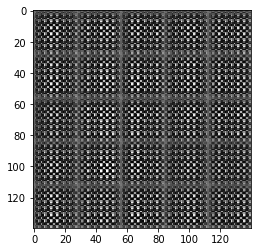

Epoch 1/2... Discriminator Loss: 0.0385... Generator Loss: 3.5723
Epoch 1/2... Discriminator Loss: 0.0282... Generator Loss: 3.8320
Epoch 1/2... Discriminator Loss: 0.0019... Generator Loss: 11.0798
Epoch 1/2... Discriminator Loss: 0.0044... Generator Loss: 5.8436
Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 7.0086


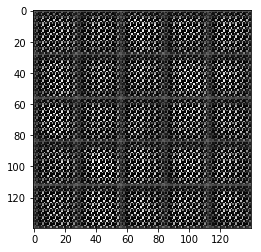

Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 7.0692
Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 7.4182
Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 7.6121
Epoch 1/2... Discriminator Loss: 0.0021... Generator Loss: 6.5003
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 6.9021


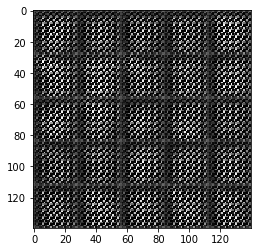

Epoch 1/2... Discriminator Loss: 0.0013... Generator Loss: 7.0832
Epoch 1/2... Discriminator Loss: 0.0062... Generator Loss: 7.6390
Epoch 1/2... Discriminator Loss: 0.0036... Generator Loss: 7.6665
Epoch 1/2... Discriminator Loss: 0.0140... Generator Loss: 7.4085
Epoch 1/2... Discriminator Loss: 0.0141... Generator Loss: 5.3279


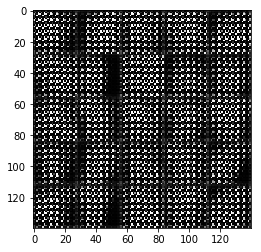

Epoch 1/2... Discriminator Loss: 0.1015... Generator Loss: 3.2822
Epoch 1/2... Discriminator Loss: 0.1933... Generator Loss: 5.8914
Epoch 1/2... Discriminator Loss: 0.0960... Generator Loss: 3.9662
Epoch 1/2... Discriminator Loss: 0.1477... Generator Loss: 2.8332
Epoch 1/2... Discriminator Loss: 0.0963... Generator Loss: 3.6935


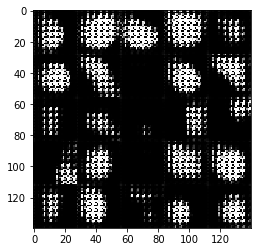

Epoch 1/2... Discriminator Loss: 0.1280... Generator Loss: 2.7322
Epoch 1/2... Discriminator Loss: 0.0319... Generator Loss: 4.6629
Epoch 1/2... Discriminator Loss: 0.0156... Generator Loss: 5.5088
Epoch 1/2... Discriminator Loss: 0.0163... Generator Loss: 5.1423
Epoch 1/2... Discriminator Loss: 0.0388... Generator Loss: 4.7126


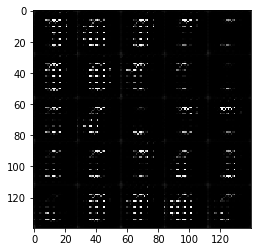

Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 10.1671
Epoch 1/2... Discriminator Loss: 0.0905... Generator Loss: 4.0391
Epoch 1/2... Discriminator Loss: 0.2764... Generator Loss: 2.6183
Epoch 1/2... Discriminator Loss: 0.3948... Generator Loss: 1.8626
Epoch 1/2... Discriminator Loss: 0.2337... Generator Loss: 2.8459


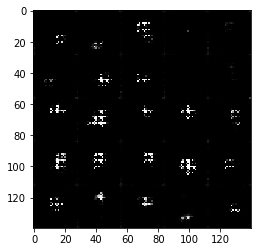

Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 1.8624
Epoch 1/2... Discriminator Loss: 0.3871... Generator Loss: 2.1342
Epoch 1/2... Discriminator Loss: 0.4579... Generator Loss: 1.8775
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 1.6563
Epoch 1/2... Discriminator Loss: 1.2112... Generator Loss: 0.5149


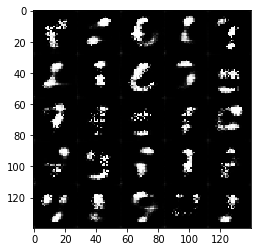

Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 0.6895... Generator Loss: 2.8168
Epoch 1/2... Discriminator Loss: 0.6144... Generator Loss: 1.7537
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 2.3736


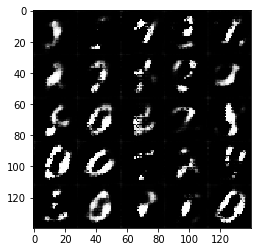

Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 1.0631
Epoch 2/2... Discriminator Loss: 1.8632... Generator Loss: 2.0185
Epoch 2/2... Discriminator Loss: 1.1964... Generator Loss: 0.7784
Epoch 2/2... Discriminator Loss: 1.6262... Generator Loss: 1.0138
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 1.1948


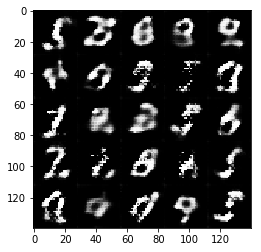

Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.3591
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 1.5590... Generator Loss: 0.5122
Epoch 2/2... Discriminator Loss: 1.1697... Generator Loss: 0.6219
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.8446


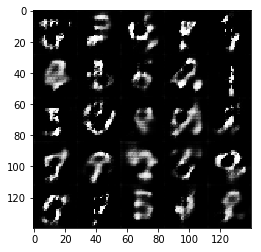

Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.1208
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.7390
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 1.1683
Epoch 2/2... Discriminator Loss: 1.4582... Generator Loss: 1.0781
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.8945


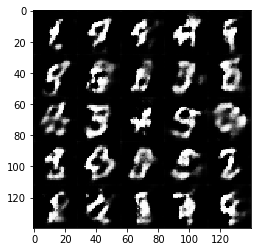

Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.4885
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 1.2279... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.0986... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.8363


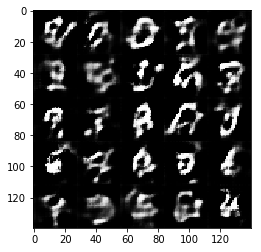

Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 1.0617
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 0.6915


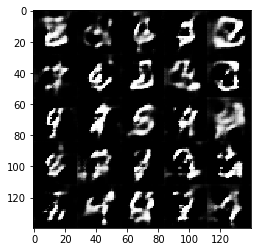

Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.7211
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.1770... Generator Loss: 1.0244
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 1.0238
Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 0.8745


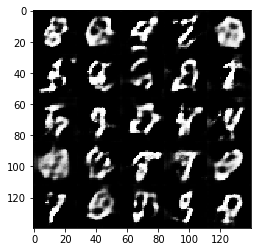

Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 1.1110
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 1.0159
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 1.2166... Generator Loss: 1.0062


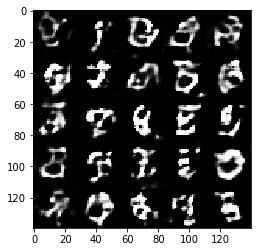

Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 1.1910... Generator Loss: 1.0874
Epoch 2/2... Discriminator Loss: 1.1167... Generator Loss: 1.0397
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.7001


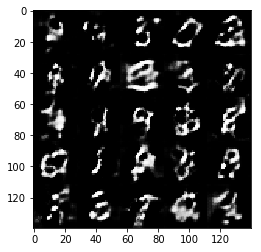

Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 1.1575... Generator Loss: 0.9032
Epoch 2/2... Discriminator Loss: 1.0891... Generator Loss: 1.1292
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 1.0316


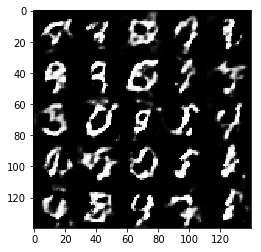

Epoch 2/2... Discriminator Loss: 1.1636... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 1.1699


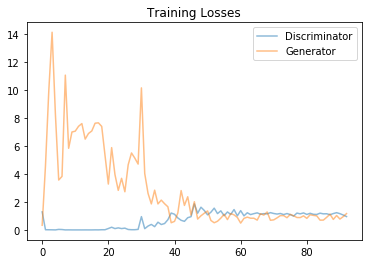

In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2239... Generator Loss: 7.2694
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 7.7440
Epoch 1/1... Discriminator Loss: 0.0422... Generator Loss: 9.0396
Epoch 1/1... Discriminator Loss: 0.0306... Generator Loss: 4.3326


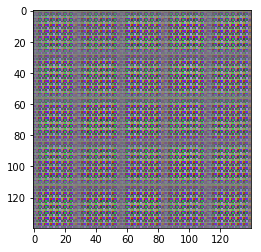

Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 5.4234
Epoch 1/1... Discriminator Loss: 0.0117... Generator Loss: 5.7751
Epoch 1/1... Discriminator Loss: 0.3128... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 0.1636... Generator Loss: 2.1090
Epoch 1/1... Discriminator Loss: 0.0404... Generator Loss: 3.9035


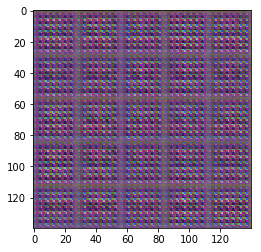

Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 4.9565
Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 13.3231
Epoch 1/1... Discriminator Loss: 0.0937... Generator Loss: 2.7955
Epoch 1/1... Discriminator Loss: 0.1453... Generator Loss: 15.0781
Epoch 1/1... Discriminator Loss: 0.0836... Generator Loss: 7.7612


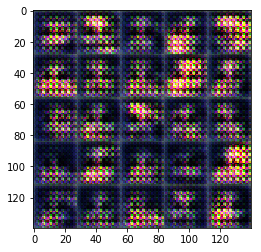

Epoch 1/1... Discriminator Loss: 0.1322... Generator Loss: 2.9724
Epoch 1/1... Discriminator Loss: 0.2701... Generator Loss: 2.0852
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 2.5499
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 1.6063


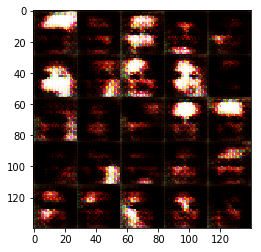

Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 1.9436
Epoch 1/1... Discriminator Loss: 0.2875... Generator Loss: 2.7611
Epoch 1/1... Discriminator Loss: 0.1583... Generator Loss: 4.2078
Epoch 1/1... Discriminator Loss: 0.2109... Generator Loss: 2.3552
Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 1.9335


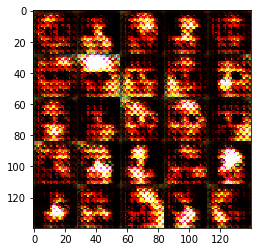

Epoch 1/1... Discriminator Loss: 0.0628... Generator Loss: 4.3725
Epoch 1/1... Discriminator Loss: 0.1291... Generator Loss: 3.1945
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 2.6463
Epoch 1/1... Discriminator Loss: 0.1034... Generator Loss: 2.9726
Epoch 1/1... Discriminator Loss: 0.0589... Generator Loss: 4.8587


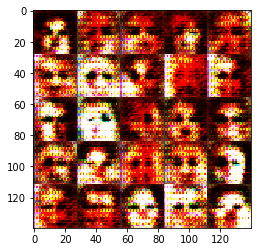

Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 3.2729
Epoch 1/1... Discriminator Loss: 0.1251... Generator Loss: 3.9760
Epoch 1/1... Discriminator Loss: 0.0742... Generator Loss: 3.5526
Epoch 1/1... Discriminator Loss: 0.1714... Generator Loss: 2.9234
Epoch 1/1... Discriminator Loss: 0.0763... Generator Loss: 4.8107


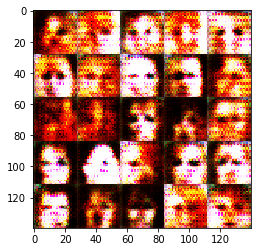

Epoch 1/1... Discriminator Loss: 0.1255... Generator Loss: 4.0963
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 3.7647
Epoch 1/1... Discriminator Loss: 0.0571... Generator Loss: 3.8933
Epoch 1/1... Discriminator Loss: 0.1050... Generator Loss: 3.2541
Epoch 1/1... Discriminator Loss: 0.0679... Generator Loss: 4.1165


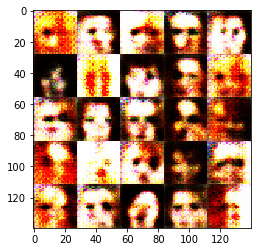

Epoch 1/1... Discriminator Loss: 0.0732... Generator Loss: 3.9243
Epoch 1/1... Discriminator Loss: 0.2045... Generator Loss: 5.4558
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 1.9092
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.8763
Epoch 1/1... Discriminator Loss: 3.5777... Generator Loss: 10.3691


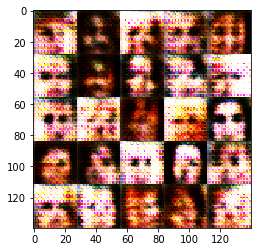

Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 1.7912
Epoch 1/1... Discriminator Loss: 0.5941... Generator Loss: 3.1980
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 1.3325
Epoch 1/1... Discriminator Loss: 0.1088... Generator Loss: 3.3095
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.4749


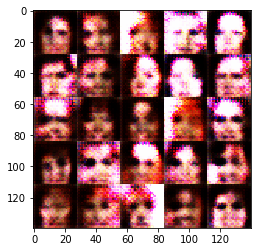

Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 5.2881
Epoch 1/1... Discriminator Loss: 0.2293... Generator Loss: 3.8630
Epoch 1/1... Discriminator Loss: 0.4157... Generator Loss: 1.6409
Epoch 1/1... Discriminator Loss: 3.8990... Generator Loss: 5.5477
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.4203


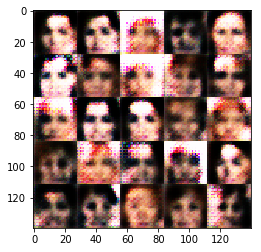

Epoch 1/1... Discriminator Loss: 0.2361... Generator Loss: 3.3447
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 2.4735
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 1.7246
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.4488


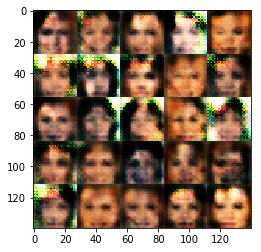

Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 2.3435
Epoch 1/1... Discriminator Loss: 0.3146... Generator Loss: 3.0999


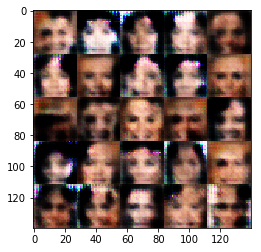

Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.4070
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5103


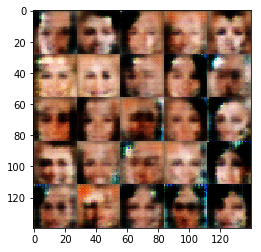

Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.5891
Epoch 1/1... Discriminator Loss: 2.0617... Generator Loss: 0.1937
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 2.4782
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 0.9326


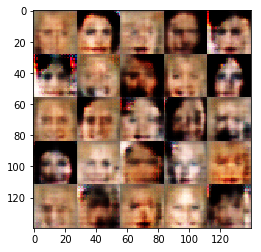

Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.6567
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.6221


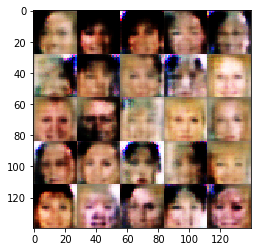

Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.9500


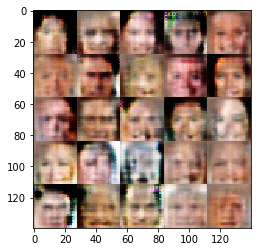

Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.3224
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.3412
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.7482... Generator Loss: 0.2788


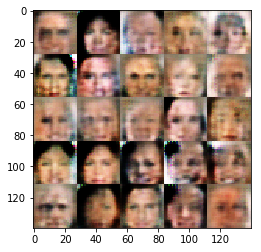

Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.7074
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.7375... Generator Loss: 2.1397
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.7119


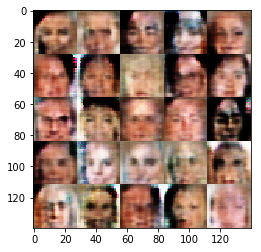

Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 0.8874... Generator Loss: 2.4905
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 0.9500


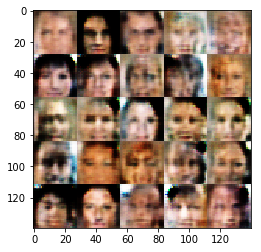

Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.5574
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 2.0750
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.9618


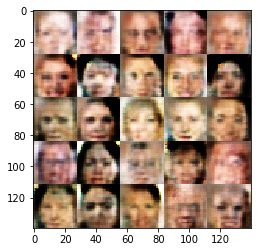

Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 1.2261
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 1.4703


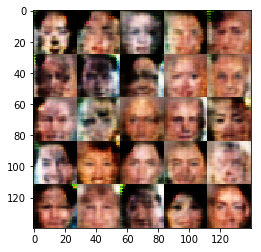

Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 3.1075
Epoch 1/1... Discriminator Loss: 1.9848... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 1.7563... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.6527


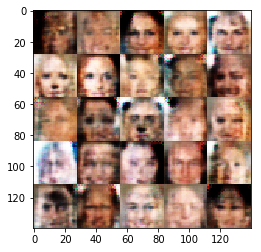

Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.6875


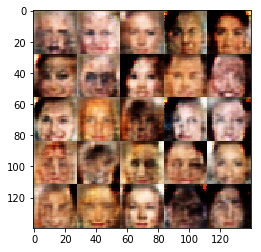

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.5442
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9608


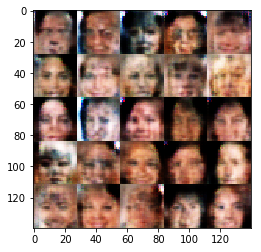

Epoch 1/1... Discriminator Loss: 2.0652... Generator Loss: 2.6836
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6195


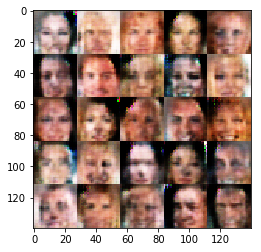

Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.1688


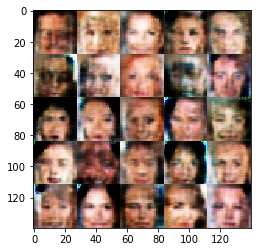

Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 2.5851
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.8702
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 0.9038


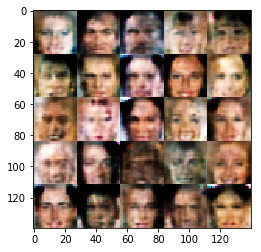

Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.3326
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 1.4120


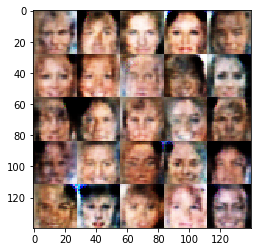

Epoch 1/1... Discriminator Loss: 2.1474... Generator Loss: 1.4009
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.7156
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.3845
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.2231


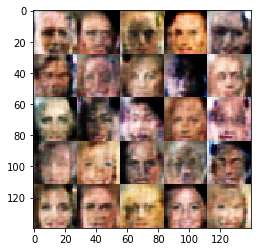

Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 1.5281
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.9040


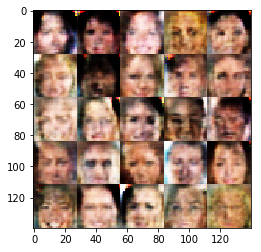

Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 1.8572
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.9872


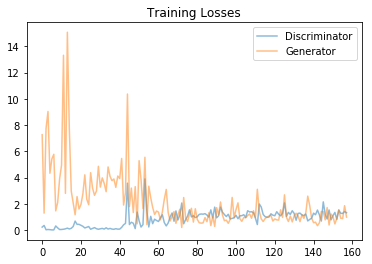

In [15]:
batch_size = 128
z_dim = 150
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.